In [4]:

# SETUP
!pip install nltk scikit-learn wordcloud seaborn matplotlib --quiet

import pandas as pd, numpy as np, re
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from wordcloud import WordCloud
from collections import Counter

nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (9,5)




In [5]:

# LOAD DATA
df = pd.read_csv('netflix_titles.csv')
print("Shape:", df.shape)
df.head()




Shape: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [8]:
# CLEANING & FEATURE ENGINEERING
df.columns = df.columns.str.strip().str.lower()

# Handle missing values
df['type']        = df['type'].str.title().fillna('Unknown')
df['listed_in']   = df['listed_in'].fillna('')
df['country']     = df['country'].fillna('Unknown').apply(lambda x: x.split(',')[0].strip())
df['description'] = df['description'].fillna('')

# Convert date
if 'date_added' in df.columns:
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
    df['year_added'] = df['date_added'].dt.year

# Runtime extraction
def parse_runtime(x):
    if pd.isna(x): return np.nan
    m = re.search(r'(\d+)\s*min', str(x))
    if m: return int(m.group(1))
    s = re.search(r'(\d+)\s*Season', str(x))
    if s: return int(s.group(1))*30
    return np.nan

if 'duration' in df.columns:
    df['runtime_min'] = df['duration'].apply(parse_runtime)

# Genre list
df['genres'] = df['listed_in'].apply(lambda x: [g.strip() for g in str(x).split(',')])



In [10]:
# Combined text for NLP
df['text'] = (
    df['title'].fillna('') + '. ' +
    df['description'].fillna('') + '. ' +
    df['listed_in'].fillna('')
)

print("Columns now:", df.columns.tolist())
print("Missing values:\n", df.isna().sum().sort_values(ascending=False).head())



Columns now: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description', 'year_added', 'runtime_min', 'genres', 'text']
Missing values:
 director      2634
cast           825
date_added      98
year_added      98
rating           4
dtype: int64


In [40]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,runtime_min,genres,text,text_clean,cluster,cast_list,country_list
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0,90.0,[Documentaries],Dick Johnson Is Dead. As her father nears the ...,dick johnson dead father nears end life filmma...,6,[],[United States]
1,s2,Tv Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,60.0,"[International TV Shows, TV Dramas, TV Mysteries]",Blood & Water. After crossing paths at a party...,blood water crossing paths party cape town tee...,1,"[Ama Qamata, Khosi Ngema, Gail Mabalane, Thaba...",[South Africa]
2,s3,Tv Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021.0,30.0,"[Crime TV Shows, International TV Shows, TV Ac...",Ganglands. To protect his family from a powerf...,ganglands protect family powerful drug lord sk...,1,"[Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nab...",[Unknown]
3,s4,Tv Show,Jailbirds New Orleans,NaN,,Unknown,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021.0,30.0,"[Docuseries, Reality TV]","Jailbirds New Orleans. Feuds, flirtations and ...",jailbirds new orleans feuds flirtations toilet...,0,[],[Unknown]
4,s5,Tv Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021.0,60.0,"[International TV Shows, Romantic TV Shows, TV...",Kota Factory. In a city of coaching centers kn...,kota factory city coaching centers known train...,1,"[Mayur More, Jitendra Kumar, Ranjan Raj, Alam ...",[India]


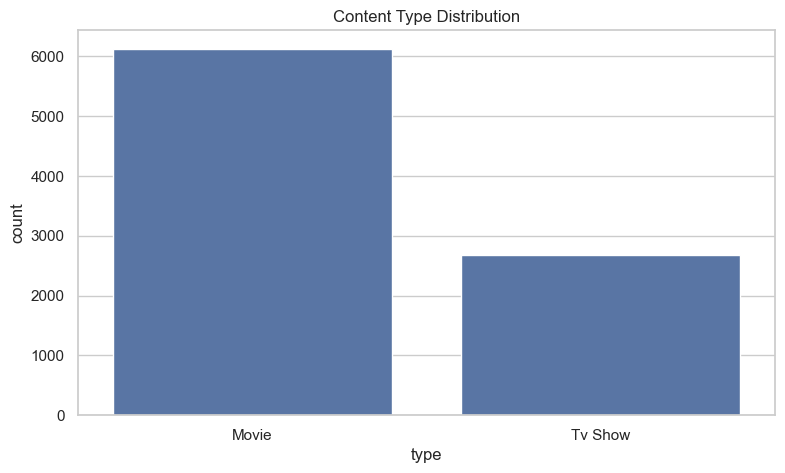

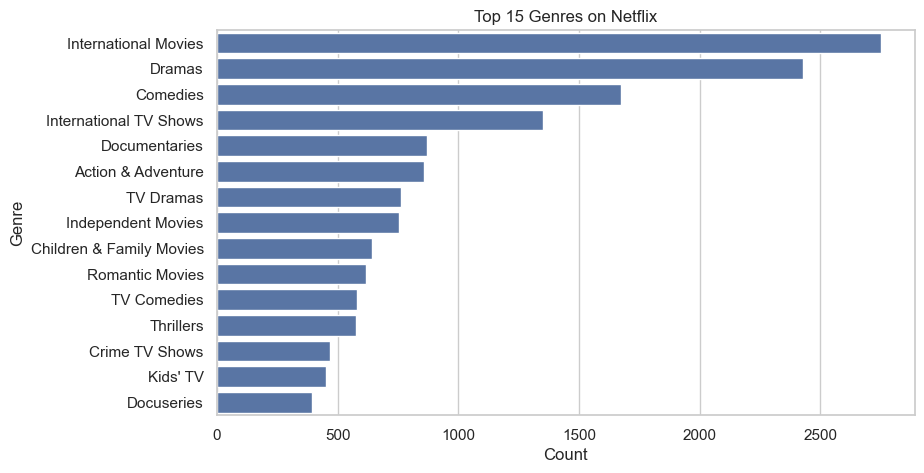

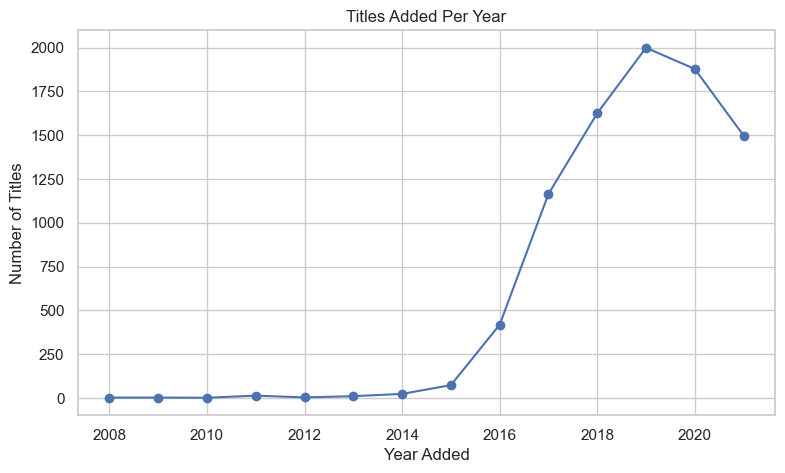

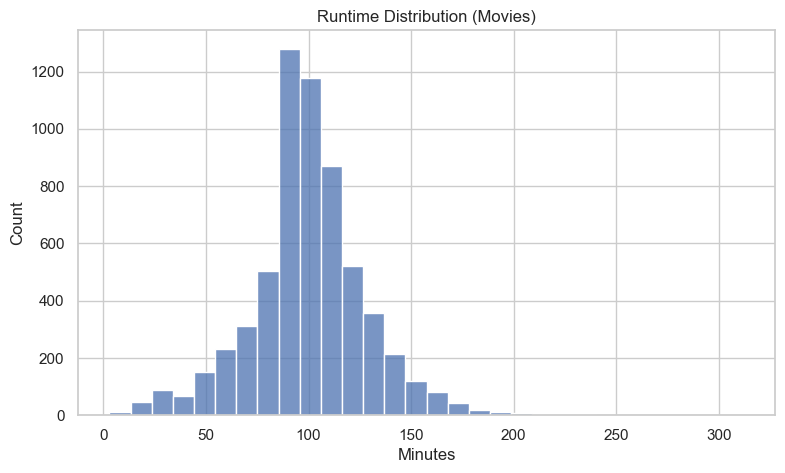

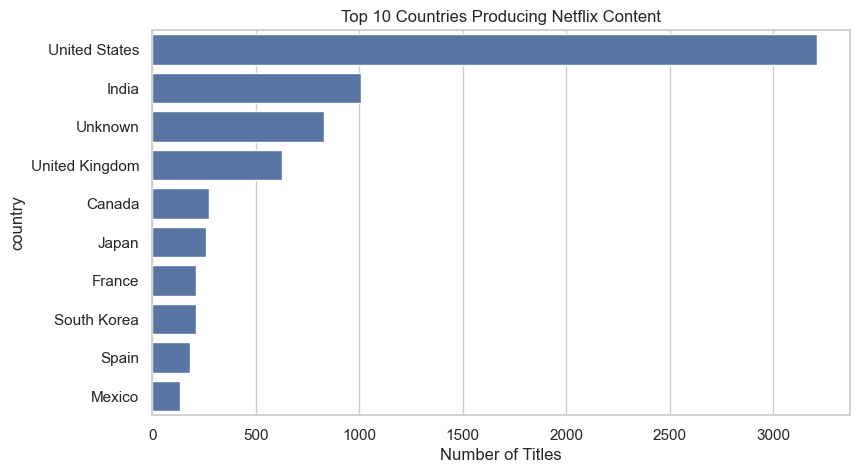

In [25]:
# EXPLORATORY DATA ANALYSIS
# Type distribution
sns.countplot(x='type', data=df, order=df['type'].value_counts().index)
plt.title('Content Type Distribution')
plt.show()
# Top Genres
genre_count = Counter([g for sub in df['genres'] for g in sub if g])
top_genres = pd.DataFrame(genre_count.most_common(15), columns=['Genre','Count'])
sns.barplot(y='Genre', x='Count', data=top_genres)
plt.title('Top 15 Genres on Netflix')
plt.show()

# Titles Added per Year
if 'year_added' in df.columns:
    df['year_added'].dropna().astype(int).value_counts().sort_index().plot(marker='o')
    plt.title('Titles Added Per Year')
    plt.xlabel('Year Added'); plt.ylabel('Number of Titles')
    plt.show()

# Runtime distribution
if 'runtime_min' in df.columns and df['runtime_min'].notna().sum()>0:
    sns.histplot(df[df['type']=='Movie']['runtime_min'].dropna(), bins=30)
    plt.title('Runtime Distribution (Movies)')
    plt.xlabel('Minutes'); plt.show()

# Country distribution (top 10)
top_countries = df['country'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries Producing Netflix Content')
plt.xlabel('Number of Titles')
plt.show()


In [27]:
# TEXT PREPROCESSING
def clean_text(t):
    t = t.lower()
    t = re.sub(r'http\S+', '', t)
    t = re.sub(r'[^a-z0-9\s]', ' ', t)
    toks = [w for w in t.split() if w not in stop_words and len(w)>2]
    return ' '.join(toks)

df['text_clean'] = df['text'].apply(clean_text)



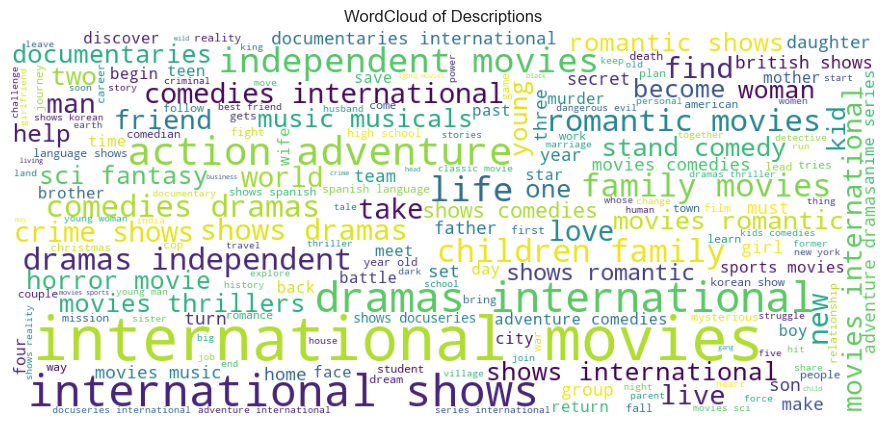

In [29]:
from PIL import Image
import numpy as np

wc = WordCloud(width=900, height=400, background_color='white') \
        .generate(" ".join(df['text_clean']))

img = wc.to_image()              # Convert to PIL Image
img_array = np.array(img)        # Safe NumPy conversion

plt.figure(figsize=(12,5))
plt.imshow(img_array)
plt.axis('off')
plt.title('WordCloud of Descriptions')
plt.show()


Cluster 0 → kids , reality , friends , series , comedies , adventures , world , fun , rangers , power
Cluster 1 → shows , international , crime , romantic , dramas , series , british , spanish , docuseries , language
Cluster 2 → action , adventure , movies , international , fantasy , sci , dramas , comedies , man , must
Cluster 3 → children , family , movies , comedies , christmas , bheem , save , new , little , must
Cluster 4 → movies , dramas , international , comedies , independent , thrillers , romantic , horror , young , woman
Cluster 5 → stand , comedy , comedian , special , comic , talk , stage , show , live , takes
Cluster 6 → documentaries , documentary , docuseries , movies , sports , nature , science , international , world , life
Cluster 7 → music , musicals , movies , documentaries , international , comedies , musical , band , dramas , rock


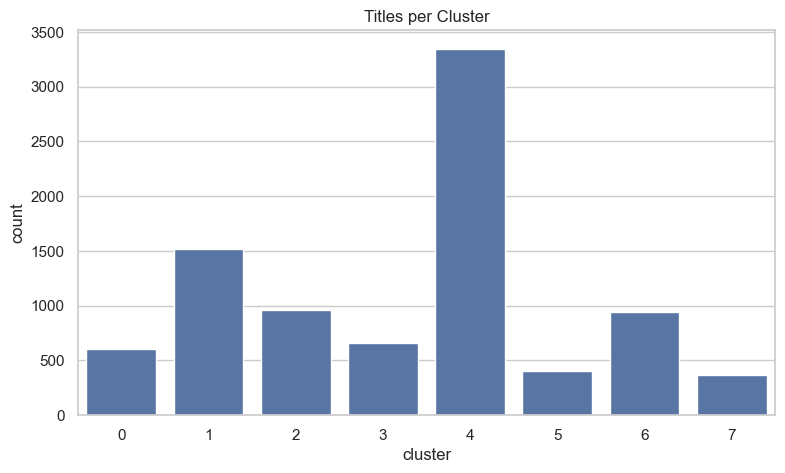

In [44]:
#  TF-IDF + KMeans CLUSTERING
# What -Converts text into numerical vectors using TF-IDF - Applies KMeans clustering (k = 8) - Labels each title with a cluster - Displays top keywords per cluster
# Why -Groups similar content and discovers latent thematic categories.

tfidf = TfidfVectorizer(max_df=0.7, min_df=5, max_features=5000)
X = tfidf.fit_transform(df['text_clean'])

k = 8
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

terms = tfidf.get_feature_names_out()
order = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(k):
    top = [terms[ind] for ind in order[i,:10]]
    print(f"Cluster {i} → {' , '.join(top)}")

sns.countplot(x='cluster', data=df)
plt.title('Titles per Cluster')
plt.show()



In [48]:
# CONTENT-BASED RECOMMENDER - Uses cosine similarity on TF-IDF vectors - Recommends titles similar to a given input title
def recommend(title, top_n=10):
    if title not in df['title'].values:
        print("Title not found."); return pd.DataFrame()
    idx = df[df['title']==title].index[0]
    vec = X[idx]
    sims = cosine_similarity(vec, X).flatten()
    sim_idx = sims.argsort()[::-1][1:top_n+1]
    return df.iloc[sim_idx][['title','type','listed_in','description']]

# 🔍 Example
recos = recommend('House of Cards', top_n=5)
display(recos)


,title,type,listed_in,description
1201,Abla Fahita: Drama Queen,Tv Show,"Crime TV Shows, International TV Shows, TV Com...","Falsely incriminated, Abla Fahita is separated..."
6272,Before the Flood,Movie,Documentaries,Leonardo DiCaprio crisscrosses the globe to in...
1701,American Horror Story,Tv Show,"TV Horror, TV Mysteries, TV Thrillers",This twisted Emmy-winning drama plays upon the...
526,Orange Is the New Black,Tv Show,"TV Comedies, TV Dramas",A privileged New Yorker ends up in a women's p...
3904,The Ruthless,Movie,"Dramas, International Movies",A rebellious teen grows up to become one of Mi...


In [50]:

# SAVE RESULTS - Allows reuse for reporting, dashboards, or deployment.
df.to_csv('netflix_with_clusters.csv', index=False)
print("✅ Saved: netflix_with_clusters.csv")


✅ Saved: netflix_with_clusters.csv


In [52]:
#IMPROVED RECOMMENDER SYSTEM (TEXT + GENRE + CAST + COUNTRY)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler

# 1️ Handle missing key fields
for col in ['cast', 'country', 'listed_in']:
    df[col] = df[col].fillna('')

# 2️ Process lists for genres, cast, and country
df['genres'] = df['listed_in'].apply(lambda x: [i.strip() for i in str(x).split(',') if i.strip()])
df['cast_list'] = df['cast'].apply(lambda x: [i.strip() for i in str(x).split(',') if i.strip()])
df['country_list'] = df['country'].apply(lambda x: [i.strip() for i in str(x).split(',') if i.strip()])

# 3️ Encode multi-label features
mlb_genre = MultiLabelBinarizer()
mlb_cast = MultiLabelBinarizer()
mlb_country = MultiLabelBinarizer()

genre_encoded = mlb_genre.fit_transform(df['genres'])
cast_encoded = mlb_cast.fit_transform(df['cast_list'])
country_encoded = mlb_country.fit_transform(df['country_list'])

# 4️ Compute similarity matrices
tfidf = TfidfVectorizer(stop_words='english', max_features=7000)
text_features = tfidf.fit_transform(df['text_clean'])

text_sim = cosine_similarity(text_features)
genre_sim = cosine_similarity(genre_encoded)
cast_sim = cosine_similarity(cast_encoded)
country_sim = cosine_similarity(country_encoded)

# 5️ Weighted hybrid similarity
# You can tune these weights (must sum up roughly to 1.0)
alpha_text, alpha_genre, alpha_cast, alpha_country = 0.6, 0.2, 0.15, 0.05

hybrid_sim = (
    alpha_text * text_sim +
    alpha_genre * genre_sim +
    alpha_cast * cast_sim +
    alpha_country * country_sim
)

# 6 Recommendation function
def recommend_hybrid(title, top_n=10):
    if title not in df['title'].values:
        print("❌❌❌ Title not found in dataset.❌❌❌")
        return pd.DataFrame()

    idx = df[df['title'] == title].index[0]
    sims = hybrid_sim[idx]
    indices = sims.argsort()[::-1][1:top_n+1]
    recs = df.iloc[indices][['title', 'type', 'listed_in', 'cast', 'country', 'description']].copy()
    recs['similarity_score'] = sims[indices]
    return recs

# 7️ Tried some examples ...!!!
example_titles = ["Breaking Bad", "Stranger Things", "Money Heist", "House of Cards"]

for title in example_titles:
    if title in df['title'].values:
        print(f"\n🎬 Recommendations similar to: {title}\n")
        display(recommend_hybrid(title, top_n=5))


🎬 Recommendations similar to: Breaking Bad



,title,type,listed_in,cast,country,description,similarity_score
2931,Better Call Saul,Tv Show,"Crime TV Shows, TV Comedies, TV Dramas","Bob Odenkirk, Jonathan Banks, Michael McKean, ...",United States,"This Emmy-nominated prequel to ""Breaking Bad"" ...",0.329225
1477,Dare Me,Tv Show,"Crime TV Shows, TV Dramas, TV Thrillers","Willa Fitzgerald, Herizen Guardiola, Marlo Kel...",United States,Relationships topple and loyalties flip when a...,0.315697
2767,Ozark,Tv Show,"Crime TV Shows, TV Dramas, TV Thrillers","Jason Bateman, Sofia Hublitz, Laura Linney, Sk...",United States,A financial adviser drags his family from Chic...,0.302826
3762,Designated Survivor,Tv Show,"Crime TV Shows, TV Dramas, TV Thrillers","Kiefer Sutherland, Natascha McElhone, Maggie Q...",United States,America's fate rests in the hands of a low-lev...,0.284978
8397,The Lizzie Borden Chronicles,Tv Show,"Crime TV Shows, TV Dramas, TV Thrillers","Christina Ricci, Clea DuVall, Cole Hauser, Dyl...",United States,Exonerated in the murder of her father and ste...,0.284499



🎬 Recommendations similar to: Stranger Things



,title,type,listed_in,cast,country,description,similarity_score
5200,Beyond Stranger Things,Tv Show,"Stand-Up Comedy & Talk Shows, TV Mysteries, TV...","Jim Rash, Matt Duffer, Ross Duffer, Shawn Levy...",United States,"Secrets from the ""Stranger Things 2"" universe ...",0.444721
3187,Nightflyers,Tv Show,"TV Horror, TV Mysteries, TV Sci-Fi & Fantasy","Eoin Macken, David Ajala, Jodie Turner-Smith, ...",United States,"With humankind's future at stake, a group of s...",0.329673
6953,Helix,Tv Show,"TV Horror, TV Mysteries, TV Sci-Fi & Fantasy","Billy Campbell, Hiroyuki Sanada, Kyra Zagorsky...",United States,While investigating a possible outbreak at an ...,0.323600
1473,Chilling Adventures of Sabrina,Tv Show,"TV Horror, TV Mysteries, TV Sci-Fi & Fantasy","Kiernan Shipka, Ross Lynch, Miranda Otto, Lucy...",United States,"Magic and mischief collide as half-human, half...",0.303849
241,Manifest,Tv Show,"TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy","Melissa Roxburgh, Josh Dallas, Athena Karkanis...",United States,When a plane mysteriously lands years after ta...,0.285978



🎬 Recommendations similar to: House of Cards



,title,type,listed_in,cast,country,description,similarity_score
3762,Designated Survivor,Tv Show,"Crime TV Shows, TV Dramas, TV Thrillers","Kiefer Sutherland, Natascha McElhone, Maggie Q...",United States,America's fate rests in the hands of a low-lev...,0.316025
6146,American Odyssey,Tv Show,"TV Dramas, TV Thrillers","Anna Friel, Peter Facinelli, Jake Robinson, Ji...",United States,"An elite soldier, a corporate lawyer and a pol...",0.297752
3065,Messiah,Tv Show,"TV Dramas, TV Thrillers","Michelle Monaghan, Mehdi Dehbi, John Ortiz, To...",United States,A wary CIA officer investigates a charismatic ...,0.296050
5147,TURN: Washington's Spies,Tv Show,TV Dramas,"Jamie Bell, Seth Numrich, Daniel Henshall, Hea...",United States,"Set in 1778, this period drama recounts the st...",0.284863
5744,Containment,Tv Show,"TV Dramas, TV Thrillers","David Gyasi, Christina Marie Moses, Chris Wood...",United States,When a ferocious contagion sweeps through Atla...,0.269646
